In [2]:
!pip install -q efficientnet >> /dev/null

In [3]:
import pandas as pd, numpy as np
from kaggle_datasets import KaggleDatasets
import tensorflow as tf, re, math
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from functools import partial

## Configuration
In order to be a proper cross validation with a meaningful overall CV score (aligned with LB score), **you need to choose the same** `IMG_SIZES`, `INC2019`, `INC2018`, and `EFF_NETS` **for each fold**. If your goal is to just run lots of experiments, then you can choose to have a different experiment in each fold. Then each fold is like a holdout validation experiment. When you find a configuration you like, you can use that configuration for all folds. 
* DEVICE - is GPU or TPU
* SEED - a different seed produces a different triple stratified kfold split.
* FOLDS - number of folds. Best set to 3, 5, or 15 but can be any number between 2 and 15
* IMG_SIZES - is a Python list of length FOLDS. These are the image sizes to use each fold
* INC2019 - This includes the new half of the 2019 competition data. The second half of the 2019 data is the comp data from 2018 plus 2017
* INC2018 - This includes the second half of the 2019 competition data which is the comp data from 2018 plus 2017
* BATCH_SIZES - is a list of length FOLDS. These are batch sizes for each fold. For maximum speed, it is best to use the largest batch size your GPU or TPU allows.
* EPOCHS - is a list of length FOLDS. These are maximum epochs. Note that each fold, the best epoch model is saved and used. So if epochs is too large, it won't matter.
* EFF_NETS - is a list of length FOLDS. These are the EfficientNets to use each fold. The number refers to the B. So a number of `0` refers to EfficientNetB0, and `1` refers to EfficientNetB1, etc.
* WGTS - this should be `1/FOLDS` for each fold. This is the weight when ensembling the folds to predict the test set. If you want a weird ensemble, you can use different weights.
* TTA - test time augmentation. Each test image is randomly augmented and predicted TTA times and the average prediction is used. TTA is also applied to OOF during validation.

In [4]:
DEVICE = "TPU" #or "GPU"

# USE DIFFERENT SEED FOR DIFFERENT STRATIFIED KFOLD
SEED = 42

# NUMBER OF FOLDS. USE 3, 5, OR 15 
FOLDS = 3

# WHICH IMAGE SIZES TO LOAD EACH FOLD
# CHOOSE 128, 192, 256, 384, 512, 768 
IMG_SIZES = [384,384,384]

# INCLUDE OLD COMP DATA? YES=1 NO=0
INC2019 = [0,0,0]
INC2018 = [1,1,1]

# BATCH SIZE AND EPOCHS
BATCH_SIZES = [32]*FOLDS
EPOCHS = [15]*FOLDS

# WEIGHTS FOR FOLD MODELS WHEN PREDICTING TEST
WGTS = [1/FOLDS]*FOLDS

# TEST TIME AUGMENTATION STEPS
TTA = 11

# WHETHER TO INCLUDE METADATA OR NOT
IMG_ONLY = True

In [5]:
if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            tf.config.experimental_connect_to_cluster(tpu)
            tf.tpu.experimental.initialize_tpu_system(tpu)
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

AUTO     = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


# Step 1: Preprocess
Preprocess has already been done and saved to TFRecords. Here we choose which size to load. We can use either 128x128, 192x192, 256x256, 384x384, 512x512, 768x768 by changing the `IMG_SIZES` variable in the preceeding code section. These TFRecords are discussed [here][1]. The advantage of using different input sizes is discussed [here][2]

[1]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/155579
[2]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/160147

In [6]:
DATA_PATH = [None]*FOLDS; DATA_PATH2 = [None]*FOLDS
for i,k in enumerate(IMG_SIZES):
    DATA_PATH[i] = KaggleDatasets().get_gcs_path('melanoma-%ix%i'%(k,k))
    DATA_PATH2[i] = KaggleDatasets().get_gcs_path('isic2019-%ix%i'%(k,k))
files_train = np.sort(np.array(tf.io.gfile.glob(DATA_PATH[0] + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(DATA_PATH[0] + '/test*.tfrec')))

In [7]:
DATA_PATH2

['gs://kds-daa129e989ec157e205de7addb63ac52a6bb066eb3efea7e285641dd',
 'gs://kds-daa129e989ec157e205de7addb63ac52a6bb066eb3efea7e285641dd',
 'gs://kds-daa129e989ec157e205de7addb63ac52a6bb066eb3efea7e285641dd']

In [8]:
files_train

array(['gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/train00-2182.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/train01-2185.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/train02-2193.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/train03-2182.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/train04-2167.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/train05-2171.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/train06-2175.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/train07-2174.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/train08-2177.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/train09-2178.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1

In [9]:
files_test

array(['gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/test00-687.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/test01-687.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/test02-687.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/test03-687.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/test04-687.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/test05-687.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/test06-687.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/test07-687.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/test08-687.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa268/test09-687.tfrec',
       'gs://kds-e587a221f0797cf8f017657b99d05aee1f262e04db020e07144fa

# Step 2: Data Augmentation
This notebook uses rotation, sheer, zoom, shift augmentation first shown in this notebook [here][1] and successfully used in Melanoma comp by AgentAuers [here][2]. This notebook also uses horizontal flip, hue, saturation, contrast, brightness augmentation similar to last years winner and also similar to AgentAuers' notebook.

Additionally we can decide to use external data by changing the variables `INC2019` and `INC2018` in the preceeding code section. These variables respectively indicate whether to load last year 2019 data and/or year 2018 + 2017 data. These datasets are discussed [here][3]

Consider experimenting with different augmenation and/or external data. The code to load TFRecords is taken from AgentAuers' notebook [here][2]. Thank you AgentAuers, this is great work.

[1]: https://www.kaggle.com/cdeotte/rotation-augmentation-gpu-tpu-0-96
[2]: https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once
[3]: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/164910

In [10]:
ROT_ = 180.0
SHR_ = 2.0
HZOOM_ = 8.0
WZOOM_ = 8.0
HSHIFT_ = 8.0
WSHIFT_ = 8.0

In [11]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))


def transform(image, DIM=256):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    XDIM = DIM%2 #fix for size 331
    
    rot = ROT_ * tf.random.normal([1], dtype='float32')
    shr = SHR_ * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / HZOOM_
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / WZOOM_
    h_shift = HSHIFT_ * tf.random.normal([1], dtype='float32') 
    w_shift = WSHIFT_ * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [24]:
def read_tfrecord(example, image_only=True, test_set=False, labeled=True, return_image_names=False):
    if not test_set:
        if labeled:
            tfrec_format = {
                'image'                        : tf.io.FixedLenFeature([], tf.string),
                'image_name'                   : tf.io.FixedLenFeature([], tf.string),
                'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
                'sex'                          : tf.io.FixedLenFeature([], tf.int64),
                'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
                'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
                'target'                       : tf.io.FixedLenFeature([], tf.int64)
            }      
        else:
            tfrec_format = {
                'image'                        : tf.io.FixedLenFeature([], tf.string),
                'image_name'                   : tf.io.FixedLenFeature([], tf.string),
                'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
                'sex'                          : tf.io.FixedLenFeature([], tf.int64),
                'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
                'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
            }
    else:
        tfrec_format = {
                'image'                        : tf.io.FixedLenFeature([], tf.string),
                'image_name'                   : tf.io.FixedLenFeature([], tf.string),
                'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
                'sex'                          : tf.io.FixedLenFeature([], tf.int64),
                'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
                'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        }
        
    example = tf.io.parse_single_example(example, tfrec_format)
    if image_only:
        if labeled:
            return ({"img_input": example['image']}, example['target'])
        else:
            return ({"img_input": example['image']}, example['image_name'] if return_image_names else 0)
    else:
        if not test_set:
            if labeled:
                return ({"img_input": example['image'],
                        "metadata_input": [example['sex'], example['age_approx'],
                                           example['anatom_site_general_challenge']]},
                        example['target'])
            
        return ({"img_input": example['image'],
                 "metadata_input": [example['sex'], example['age_approx'],
                                    example['anatom_site_general_challenge']]},
                 example['image_name'] if return_image_names else 0)

                                                                                                        
def prepare_image(features, image_only=True, augment=True, dim=256):  
    img = features['img_input']
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    
    if augment:
        img = transform(img,DIM=dim)
        img = tf.image.random_flip_left_right(img)
        #img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
                      
    img = tf.reshape(img, [dim, dim, 3])
    features['img_input'] = img
    return features

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)


# Step 3: Build Model
This is a common model architecute. Consider experimenting with different backbones, custom heads, losses, and optimizers. Also consider inputing meta features into your CNN.

In [13]:
import tensorflow_hub as hub
from tensorflow import keras
import tensorflow_addons as tfa

In [ ]:
def build_model(model_name="efficientnet_B0", dim=128, image_only=True,
                metadata_length=3, feature_vec_size=1000, normalize_features=True, 
                return_feature_model=False):
    
    def get_efficientnet(effnet_model):
        effnet_model = int(effnet_model)
        EFNS = [efn.EfficientNetB0, efn.EfficientNetB1,
                efn.EfficientNetB2, efn.EfficientNetB3, 
                efn.EfficientNetB4, efn.EfficientNetB5,
                efn.EfficientNetB6]
        return EFNS[effnet_model]

    model_dict = {
        "efficientnet": get_efficientnet,
        "resnet50": tf.keras.applications.ResNet50,
        "vgg19": tf.keras.applications.VGG19,
        "Xception": tf.keras.applications.Xception,
    }   


    # For Image Input
    img_inp = keras.layers.Input(shape=(dim, dim, 3), name="img_input")
    if model_name.find('efficientnet') != -1:
        base = model_dict['efficientnet'](model_name[-1])(input_shape=(dim,dim,3),
                                                          weights='imagenet',
                                                          include_top=False)(img_inp)
    else:
        base = model_dict[model_name](input_shape=(dim,dim,3),
                                      weights='imagenet',
                                      include_top=False)(img_inp)
    
    pooling_layer = keras.layers.GlobalAveragePooling2D()(base)

    if not image_only:
        flatten_layer = keras.layers.Flatten()(pooling_layer)
        # For metadata input
        metadata_inp = keras.layers.Input(shape=(metadata_length), name="metadata_input")

        # Concating the pooled features and metadata
        concat = keras.layers.Concatenate()([metadata_inp, flatten_layer])

        # A dense layer which will try to find a relation between image features and metadata
        feature_layer = keras.layers.Dense(feature_vec_size, activation="selu", name="featvec")(concat)

        # Normalizing the features
        normalized_feature = keras.layers.BatchNormalization(name="norm_featvec")(feature_layer)

        # Output
        output = keras.layers.Dense(1, activation="sigmoid", name="output")(normalized_feature)
    else:
        feature_layer = keras.layers.Flatten()(pooling_layer)
        normalized_feature = keras.layers.BatchNormalization(name="norm_featvec")(feature_layer)
        output = tf.keras.layers.Dense(1,activation='sigmoid')(pooling_layer)
    
    if normalize_features:
        feat_output = normalized_feature
    else:
        feat_output = feature_layer
            
    if image_only:
        if return_feature_model:
            featext_model = keras.Model(inputs=[img_inp], outputs=[feat_output])
        model = keras.Model(inputs=[img_inp], outputs=[output])
    else:
        if return_feature_model:
            featext_model = keras.Model(inputs=[metadata_inp, img_inp], outputs=[feat_output])
        model = keras.Model(inputs=[metadata_inp, img_inp], outputs=[output])
        
    model.compile(loss=tfa.losses.SigmoidFocalCrossEntropy(),
                  optimizer=keras.optimizers.Nadam(),
                  metrics=['AUC'])

    if return_feature_model:
        return model, featext_model
    else:
        return model

In [15]:
demo_model = build_model(model_name="resnet50", dim=IMG_SIZES[2], return_feature_model=False)

94773248/94765736 [==============================] - 1s 0us/step


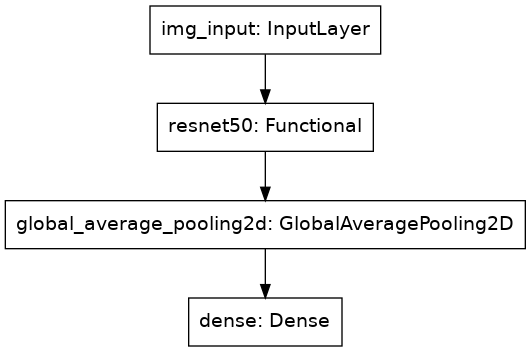

In [16]:
tf.keras.utils.plot_model(demo_model)

# Step 4: Train Schedule
This is a common train schedule for transfer learning. The learning rate starts near zero, then increases to a maximum, then decays over time. Consider changing the schedule and/or learning rates. Note how the learning rate max is larger with larger batches sizes. This is a good practice to follow.

In [17]:
def get_lr_callback(batch_size=8):
    lr_start   = 0.000005
    lr_max     = 0.00000125 * REPLICAS * batch_size
    lr_min     = 0.000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

## Train Model
Our model will be trained for the number of FOLDS and EPOCHS you chose in the configuration above. Each fold the model with lowest validation loss will be saved and used to predict OOF and test. Adjust the variables `VERBOSE` and `DISPLOY_PLOT` below to determine what output you want displayed. The variable `VERBOSE=1 or 2` will display the training and validation loss and auc for each epoch as text. The variable `DISPLAY_PLOT` shows this information as a plot. 

In [18]:
import os

root_checkpointdir = os.path.join(os.curdir, "my_checkpoints")
def get_model_checkpoint_path(model_name, fold, img_size):
    file_name = model_name+"_"+"fold"+str(fold) + "_" + str(img_size)
    path = os.path.join(root_checkpointdir, model_name)
    os.makedirs(path, exist_ok=True)
    return os.path.join(path, file_name)

In [19]:
# USE VERBOSE=0 for silent, VERBOSE=1 for interactive, VERBOSE=2 for commit
VERBOSE = 2
DISPLAY_PLOT = True

def train_model(model_name=None, EPOCHS=EPOCHS, FOLDS=FOLDS, IMG_SIZES=IMG_SIZES,
                BATCH_SIZES=BATCH_SIZES, REPLICAS=REPLICAS, SEED=SEED, DATA_PATH=DATA_PATH,
                DATA_PATH2=DATA_PATH2, TTA=TTA, VERBOSE=VERBOSE, DISPLAY_PLOT=DISPLAY_PLOT):
                #files_train=files_train, files_test=files_test):
    
    skf = KFold(n_splits=FOLDS,shuffle=True,random_state=SEED)
    oof_pred = []; oof_tar = []; oof_val = []; oof_names = []; oof_folds = [] 
    best_auc = 0
    best_fold = None
    best_model_history = None
    #preds = np.zeros((count_data_items(files_test),1))

    for fold,(idxT,idxV) in enumerate(skf.split(np.arange(15))):
        if fold != 2:
            continue
        # DISPLAY FOLD INFO
        print('#'*25); print('#### FOLD',fold+1)
        print('#### Image Size %i with %s and batch_size %i'%
              (IMG_SIZES[fold], model_name,BATCH_SIZES[fold]*REPLICAS))

        # CREATE TRAIN AND VALIDATION SUBSETS
        files_train = tf.io.gfile.glob([DATA_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxT])
        if INC2019[fold]:
            files_train += tf.io.gfile.glob([DATA_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2+1])
            print('#### Using 2019 external data')
        if INC2018[fold]:
            files_train += tf.io.gfile.glob([DATA_PATH2[fold] + '/train%.2i*.tfrec'%x for x in idxT*2])
            print('#### Using 2018+2017 external data')
        np.random.shuffle(files_train); print('#'*25)
        files_valid = tf.io.gfile.glob([DATA_PATH[fold] + '/train%.2i*.tfrec'%x for x in idxV])
        files_test = np.sort(np.array(tf.io.gfile.glob(DATA_PATH[fold] + '/test*.tfrec')))

        # BUILD MODEL
        K.clear_session()
        with strategy.scope():
            model, feat_model = build_model(model_name=model_name, dim=IMG_SIZES[fold],
                                            return_feature_model=True, image_only=IMG_ONLY)

        # SAVE BEST MODEL EACH FOLD
        checkpoint_file_path = get_model_checkpoint_path(model_name, fold, IMG_SIZES[fold])
        sv = tf.keras.callbacks.ModelCheckpoint(
            f'{checkpoint_file_path}.h5', monitor='val_loss', verbose=0, save_best_only=True,
            save_weights_only=True, mode='min', save_freq='epoch')

        # Getting DATASETS:
        train_dataset = get_dataset(files_train, augment=True, shuffle=True, repeat=True,
                                    dim=IMG_SIZES[fold],batch_size = BATCH_SIZES[fold],
                                    image_only=IMG_ONLY)
        
        valid_dataset = get_dataset(files_valid, augment=False, shuffle=False,
                                    repeat=False,dim=IMG_SIZES[fold],
                                    image_only=IMG_ONLY)
        """for item in valid_dataset.take(1):
            print(item)
        print(asdasd)"""
        # TRAIN
        print('Training...')
        history = model.fit(
                train_dataset,
                epochs=EPOCHS[fold],
                validation_data=valid_dataset, 
                callbacks = [sv,
                             get_lr_callback(BATCH_SIZES[fold])], 
                steps_per_epoch=count_data_items(files_train)/BATCH_SIZES[fold]//REPLICAS,
                #class_weight = {0:1,1:2},
                verbose=VERBOSE,
        )

        print('Loading best model...')
        model.load_weights(f'{checkpoint_file_path}.h5')
        head_tail = os.path.split(f'{checkpoint_file_path}.h5')
        feat_model.save_weights(f'{os.path.join(head_tail[0], f"feat_{model_name}")}.h5')
        # PREDICT OOF USING TTA
        print('Predicting OOF with TTA...')
        valid_dataset = get_dataset(files_valid,labeled=False,return_image_names=False,augment=True,
                                    repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4,
                                    image_only=IMG_ONLY)
        ct_valid = count_data_items(files_valid)
        STEPS = TTA * ct_valid/BATCH_SIZES[fold]/4/REPLICAS
        pred = model.predict(valid_dataset,steps=STEPS,verbose=VERBOSE)[:TTA*ct_valid,] 
        oof_pred.append(np.mean(pred.reshape((ct_valid,TTA),order='F'),axis=1) )                 
        #oof_pred.append(model.predict(get_dataset(files_valid,dim=IMG_SIZES[fold]),verbose=1))

        # GET OOF TARGETS AND NAMES
        valid_dataset = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                                     labeled=True, return_image_names=True, image_only=IMG_ONLY)
        oof_tar.append(np.array([target.numpy() for img, target in iter(valid_dataset.unbatch())]))
        oof_folds.append(np.ones_like(oof_tar[-1],dtype='int8')*fold)
        valid_dataset = get_dataset(files_valid, augment=False, repeat=False, dim=IMG_SIZES[fold],
                                    labeled=False, return_image_names=True, image_only=IMG_ONLY)
        oof_names.append(np.array([feature_dict[1].numpy().decode("utf-8") for feature_dict in iter(valid_dataset.unbatch())]))

        # PREDICT TEST USING TTA
        print('Predicting Test with TTA...')
        test_dataset = get_dataset(files_test,labeled=False,return_image_names=False,augment=True,
                                   repeat=True,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*4,
                                   image_only=IMG_ONLY)
        ct_test = count_data_items(files_test)
        STEPS = TTA * ct_test/BATCH_SIZES[fold]/4/REPLICAS
        pred = model.predict(test_dataset,steps=STEPS,verbose=VERBOSE)[:TTA*ct_test,] 
        #preds[:,0] += np.mean(pred.reshape((ct_test,TTA),order='F'),axis=1) * WGTS[fold]

        # REPORT RESULTS
        auc = roc_auc_score(oof_tar[-1],oof_pred[-1])
        if auc > best_auc:
            best_fold = fold
            best_model_history = history
        oof_val.append(np.max( history.history['val_auc'] ))
        print('#### FOLD %i OOF AUC without TTA = %.3f, with TTA = %.3f'%(fold+1,oof_val[-1],auc))

        # PLOT TRAINING
        if DISPLAY_PLOT:
            plt.figure(figsize=(15,5))
            plt.plot(np.arange(EPOCHS[fold]),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
            plt.plot(np.arange(EPOCHS[fold]),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
            x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
            xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
            plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
            plt.ylabel('AUC',size=14); plt.xlabel('Epoch',size=14)
            plt.legend(loc=2)
            plt2 = plt.gca().twinx()
            plt2.plot(np.arange(EPOCHS[fold]),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
            plt2.plot(np.arange(EPOCHS[fold]),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
            x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
            ydist = plt.ylim()[1] - plt.ylim()[0]
            plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
            plt.ylabel('Loss',size=14)
            plt.title('FOLD %i - Image Size %i, %s, inc2019=%i, inc2018=%i'%
                    (fold+1,IMG_SIZES[fold], model_name,INC2019[fold],INC2018[fold]),size=18)
            plt.legend(loc=3)
            plt.show()  
    
    root_checkpoint_dir = "my_checkpoints"
    model = build_model(model_name=model_name, dim=IMG_SIZES[best_fold])
    model.load_weights(os.path.join(root_checkpoint_dir, model_name,
                                    f'{model_name}_fold{best_fold}_{IMG_SIZES[best_fold]}.h5'))
    
    return model, best_model_history

In [20]:
def get_dataset(files, image_only=True, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=False, batch_size=16, dim=256):
    
    read_labeled_unlabeled = partial(read_tfrecord, image_only=image_only,
                                     labeled=labeled, return_image_names=return_image_names)
    #read_unlabeled_tfrecord = partial(read_tfrecord, image_only=image_only, labeled=False)
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    
    ds = ds.map(read_labeled_unlabeled, num_parallel_calls=AUTO)
    ds = ds.map(lambda features, target_or_image_names: (prepare_image(features, augment=augment, image_only=image_only,
                                                            dim=dim),
                                                         target_or_image_names),
                num_parallel_calls=AUTO)
    
    if labeled:
        ds = ds.map(lambda features, target: (features, tf.cast(target, tf.float32)),
                    num_parallel_calls=AUTO)
     
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

In [21]:
models_history = dict()
models = dict()

In [22]:
model_names_list = ['efficientnet_b3', 'efficientnet_b6', 'efficientnet_b7', 'resnet50', 'Xception', 'vgg19']
for model_name in model_names_list:
    print("\n---------------------- TRAINING MODEL {model_name} ----------------------".format(model_name=model_name))
    models[model_name], models_history[model_name] = train_model(model_name)


---------------------- TRAINING MODEL efficientnet_b6 ----------------------
#########################
#### FOLD 3
#### Image Size 384 with efficientnet_b6 and batch_size 256
#### Using 2018+2017 external data
#########################
165527552/165527152 [==============================] - 2s 0us/step
Training...
Epoch 1/15
118/118 - 336s - loss: 0.0946 - auc: 0.5371 - val_loss: 0.0901 - val_auc: 0.5723
Epoch 2/15
118/118 - 100s - loss: 0.0179 - auc: 0.7744 - val_loss: 0.0077 - val_auc: 0.8023
Epoch 3/15
118/118 - 100s - loss: 0.0140 - auc: 0.8715 - val_loss: 0.0068 - val_auc: 0.8701
Epoch 4/15
118/118 - 100s - loss: 0.0129 - auc: 0.9008 - val_loss: 0.0066 - val_auc: 0.8826
Epoch 5/15
118/118 - 99s - loss: 0.0120 - auc: 0.9163 - val_loss: 0.0067 - val_auc: 0.8943
Epoch 6/15
118/118 - 99s - loss: 0.0117 - auc: 0.9238 - val_loss: 0.0064 - val_auc: 0.9128
Epoch 7/15
118/118 - 99s - loss: 0.0107 - auc: 0.9399 - val_loss: 0.0061 - val_auc: 0.9142
Epoch 8/15
118/118 - 100s - loss: 0.0100 - 

NameError: in user code:

    <ipython-input-12-3211960beff1>:37 read_tfrecord  *
        return ({"img_input": example['image']}, example['image_name'] if return_image_name else 0)

    NameError: name 'return_image_name' is not defined


In [23]:
root_path = "./my_checkpoints"
for model_name in model_names_list:
    model_path = os.path.join(root_path, model_name)
    np.save(os.path.join(model_path, f'{model_name}_best_history.npy'),models_history[model_name].history)
    models[model_name].save_weights(os.path.join(model_path, f'{model_name}_best_weights.h5'))
    
#history1=np.load('history1.npy',allow_pickle='TRUE').item()

KeyError: 'efficientnet_b6'

## Calculate OOF AUC
The OOF (out of fold) predictions are saved to disk. If you wish to ensemble multiple models, use the OOF to determine what are the best weights to blend your models with. Choose weights that maximize OOF CV score when used to blend OOF. Then use those same weights to blend your test predictions.

In [ ]:
"""# COMPUTE OVERALL OOF AUC
oof = np.concatenate(oof_pred); true = np.concatenate(oof_tar);
names = np.concatenate(oof_names); folds = np.concatenate(oof_folds)
auc = roc_auc_score(true,oof)
print('Overall OOF AUC with TTA = %.3f'%auc)

# SAVE OOF TO DISK
df_oof = pd.DataFrame(dict(
    image_name = names, target=true, pred = oof, fold=folds))
df_oof.to_csv('oof.csv',index=False)
df_oof.head()"""

# Step 5: Post process
There are ways to modify predictions based on patient information to increase CV LB. You can experiment with that here on your OOF.

# Submit To Kaggle

In [ ]:
ds = get_dataset(files_test, augment=False, repeat=False, dim=IMG_SIZES[fold],
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

In [ ]:
submission = pd.DataFrame(dict(image_name=image_names, target=preds[:,0]))
submission = submission.sort_values('image_name') 
submission.to_csv('submission.csv', index=False)
submission.head()

In [ ]:
plt.hist(submission.target,bins=100)
plt.show()